<a href="https://colab.research.google.com/github/butoialexandra/Determining-country-specific-engagement-in-climate-change-policies/blob/main/3_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling

Code adapted from [here](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know?utm_source=datacamp&utm_medium=post&utm_campaign=blog-pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know)


Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Check you're in the right place

In [2]:
!pwd

/content


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


Download these libraries if haven't done already

In [4]:
!python -m spacy download en
!pip install pyLDAvis==3.2.1

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=42831ea8d871430bc0aa478997203f9e3d4cd59fa7aaefecb98358225cb05682
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis


Imports

In [39]:
import re
import numpy as np
import pandas as pd
import glob
import pickle
from pprint import pprint
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.porter import PorterStemmer

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load data

In [6]:
df = pd.read_csv("./data.csv") 

In [7]:
df.head(5)

,Document,NDC
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...
1,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,The means of implementation of NDCs of Sri Lan...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...
3,../txts/NER_Niger_First_NDC_Translation_Englis...,to use climate financing and benefit from the ...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...


Some processing

In [8]:
df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\\.!?0-9]', '', x))
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.lower())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.strip())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: re.sub(' +', ' ', x))
df = df[df['NDC_processed'].apply(lambda x: len(x) > 100)]

In [9]:
df = df.reset_index(drop=True)
df

,Document,NDC,NDC_processed
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...,cabo verde is committed to implement the susta...
1,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...,this updated ndc updates and strengthens the f...
2,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...,gambia watershed by a improving disaster prepa...
3,../txts/JOR_Jordan_First_NDC_English_Paragraph...,The estimated cost to reach the 14 target is t...,the estimated cost to reach the target is tota...
4,../txts/FSM_Micronesia_First_NDC_English_Parag...,"Moreover, national efforts to implement INDC i...",moreover national efforts to implement indc in...
...,...,...,...
10817,../txts/KHM_Cambodia_First_NDC_English_Paragra...,conducting surveillance and research on waterb...,conducting surveillance and research on waterb...
10818,../txts/URY_Uruguay_First_NDC_Translation_Engl...,The above chart contains a not exhaustive list...,the above chart contains a not exhaustive list...
10819,../txts/MAR_Morocco_First_NDC_Translation_Engl...,"principles to be respected by the state, local...",principles to be respected by the state local ...
10820,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,Integrated planning is the key means of implem...,integrated planning is the key means of implem...


In [ ]:
df.to_csv("data_processed.csv")

Process data for LDA

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        print([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def stemming(texts):
  p = PorterStemmer()
  return [p.stem_documents(text) for text in texts]

In [11]:
ndcs = df.NDC_processed.values.tolist()
words = list(sent_to_words(ndcs))

bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
data_words_nostops = remove_stopwords(words)

#data_words_bigrams = make_bigrams(data_words_nostops)

#nlp = spacy.load('en', disable=['parser', 'ner'])

#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_stemmed = stemming(data_words_nostops)

data_words_bigrams = make_bigrams(data_stemmed)

Make corpus

In [14]:
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

Train gensim LDA model with 10 topics

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"island" + 0.025*"increas" + 0.024*"flood" + 0.021*"temperatur" + '
  '0.020*"rise" + 0.018*"drought" + 0.017*"countri" + 0.016*"affect" + '
  '0.014*"rainfal" + 0.013*"result"'),
 (1,
  '0.091*"emiss" + 0.036*"ghg" + 0.030*"sector" + 0.030*"project" + '
  '0.027*"reduct" + 0.021*"year" + 0.019*"growth" + 0.018*"carbon" + '
  '0.016*"reduc" + 0.016*"estim"'),
 (2,
  '0.038*"nation" + 0.025*"contribut" + 0.018*"target" + 0.016*"indc" + '
  '0.015*"ndc" + 0.014*"achiev" + 0.013*"countri" + 0.011*"identifi" + '
  '0.011*"commun" + 0.011*"inform"'),
 (3,
  '0.046*"forest" + 0.045*"area" + 0.029*"natur" + 0.029*"popul" + '
  '0.025*"protect" + 0.022*"econom" + 0.018*"high" + 0.015*"peopl" + '
  '0.014*"social" + 0.014*"resourc"'),
 (4,
  '0.113*"us" + 0.041*"land" + 0.031*"data" + 0.024*"forestri" + 0.020*"ipcc" '
  '+ 0.014*"valu" + 0.014*"potenti" + 0.014*"livestock" + 0.013*"includ" + '
  '0.013*"decreas"'),
 (5,
  '0.053*"develop" + 0.037*"adapt" + 0.030*"plan" + 0.029*"im

Check perplexity and coherence score

In [17]:
print('Perplexity: {}'.format(lda_model.log_perplexity(corpus)))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: {}'.format(coherence_lda))

Perplexity: -7.249567337190181
Coherence Score: 0.5278614753593946


Visualize topics

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.252566  0.134054       1        1  24.434688
2     -0.259154 -0.006692       2        1  18.030375
1     -0.143360 -0.113570       3        1  11.962420
6      0.113938 -0.030742       4        1   9.398393
3     -0.052036 -0.104505       5        1   7.708953
8      0.087308  0.141002       6        1   7.116051
9      0.094689  0.239372       7        1   6.857648
0      0.053047 -0.247149       8        1   5.663568
4      0.157123  0.127449       9        1   5.651313
7      0.201010 -0.139219      10        1   3.176592, topic_info=            Term         Freq        Total Category  logprob  loglift
110       climat  6642.000000  6642.000000  Default  30.0000  30.0000
109        chang  5165.000000  5165.000000  Default  29.0000  29.0000
181        emiss  3946.000000  3946.000000  Default  28.0000  28.0000
9         energi  2978.000000  2978.000000  Default  27.0000  27.0000
195           us  2327.000000  2327.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1395  world_bank    90.113683    91.032644  Topic10  -4.8516   3.4392
1325     citizen    87.845074    88.763992  Topic10  -4.8771   3.4390
1476  multilater    86.656866    87.575959  Topic10  -4.8908   3.4388
1582       mobil    83.879530    84.798424  Topic10  -4.9233   3.4385
1601       usual    83.036002    83.954875  Topic10  -4.9334   3.4384

[455 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
752       2  0.999375  achiev
381       4  0.993290     act
481       1  0.997917  action
481       2  0.001957  action
219       1  0.939329   activ
...     ...       ...     ...
218       3  0.862081   would
218      10  0.134350   would
177       3  0.891739    year
177       8  0.107522    year
1155      8  0.990799    zone

[544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 4, 9, 10, 1, 5, 8])

Train LDA using Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = 'mallet-2.0.8/bin/mallet'

Train LDA with Mallet

In [20]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: {}'.format(coherence_ldamallet))

[(0,
  [('develop', 0.09691564252475839),
   ('sustain', 0.03027681660899654),
   ('countri', 0.030127669729149265),
   ('environment', 0.020522610666984846),
   ('goal', 0.015541104880085909),
   ('econom', 0.015153322992482997),
   ('social', 0.013870659825796444),
   ('ensur', 0.012587996659109892),
   ('provid', 0.011901921011812432),
   ('effort', 0.01175277413196516)]),
 (1,
  [('emiss', 0.11951789164095614),
   ('ghg', 0.044375883048355005),
   ('reduct', 0.04077160404832617),
   ('carbon', 0.024422594504195382),
   ('ga', 0.022144690176177158),
   ('greenhous', 0.021250828984170005),
   ('target', 0.019895620080159163),
   ('sector', 0.01969378045615755),
   ('data', 0.019203598512153627),
   ('scenario', 0.017790721144142325)]),
 (2,
  [('manag', 0.04818273749330795),
   ('agricultur', 0.04776634346558801),
   ('water', 0.044851585271548394),
   ('forest', 0.03673190173100946),
   ('resourc', 0.03456070430075546),
   ('land', 0.03197311284278151),
   ('area', 0.031645946106715

Converd Mallet model to gensim in order to be able to visualize topics with pyLDAvis

In [21]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

mallet_model = convertldaGenToldaMallet(ldamallet)

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.252559 -0.028710       1        1  10.499728
6      0.020785  0.295878       2        1  10.446826
4     -0.013525  0.280375       3        1  10.236464
7      0.051609 -0.226308       4        1  10.108528
0      0.105707  0.063075       5        1  10.082916
1     -0.127360  0.000638       6        1   9.823328
9      0.073745 -0.163121       7        1   9.759109
5      0.179889 -0.088689       8        1   9.739394
2     -0.248926 -0.027148       9        1   9.713603
8     -0.294483 -0.105989      10        1   9.590104, topic_info=          Term         Freq        Total Category  logprob  loglift
110     climat  6811.000000  6811.000000  Default  30.0000  30.0000
109      chang  5274.000000  5274.000000  Default  29.0000  29.0000
181      emiss  4261.000000  4261.000000  Default  28.0000  28.0000
9       energi  3400.000000  3400.000000  Default  27.0000  27.0000
20       adapt  3468.000000  3468.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
657     import   249.058599   646.959151  Topic10  -4.9399   1.3898
45     potenti   238.505257   630.212447  Topic10  -4.9832   1.3728
256  technolog   279.663256  1225.382461  Topic10  -4.8240   0.8670
367     promot   241.671265   769.137103  Topic10  -4.9701   1.1867
69        cost   196.291939   689.071058  Topic10  -5.1780   1.0887

[713 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
347       4  1.005231   academ
317       4  0.433915   access
317       5  0.470234   access
317       9  0.095576   access
80        6  0.926058  account
...     ...       ...      ...
648       7  0.937595      xvi
177       3  0.833796     year
177       6  0.166270     year
1517      5  1.001220    youth
1155      2  1.002115     zone

[873 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 8, 1, 2, 10, 6, 3, 9])

Train Mallet for different number of topics and choose the model with best coherence score

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=30, step=1)

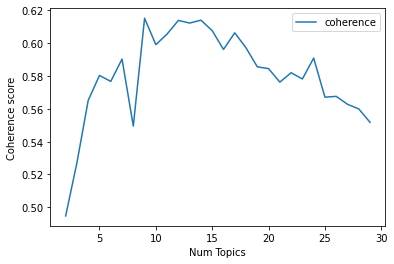

In [25]:
limit, start, step = 30, 2, 1
x = range(start, limit, step)
plt.plot(x, coherence_values, label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4947
Num Topics = 3  has Coherence Value of 0.5272
Num Topics = 4  has Coherence Value of 0.5651
Num Topics = 5  has Coherence Value of 0.5803
Num Topics = 6  has Coherence Value of 0.5767
Num Topics = 7  has Coherence Value of 0.5903
Num Topics = 8  has Coherence Value of 0.5495
Num Topics = 9  has Coherence Value of 0.6151
Num Topics = 10  has Coherence Value of 0.5991
Num Topics = 11  has Coherence Value of 0.6055
Num Topics = 12  has Coherence Value of 0.6138
Num Topics = 13  has Coherence Value of 0.6122
Num Topics = 14  has Coherence Value of 0.614
Num Topics = 15  has Coherence Value of 0.6076
Num Topics = 16  has Coherence Value of 0.5961
Num Topics = 17  has Coherence Value of 0.6063
Num Topics = 18  has Coherence Value of 0.5971
Num Topics = 19  has Coherence Value of 0.5856
Num Topics = 20  has Coherence Value of 0.5844
Num Topics = 21  has Coherence Value of 0.5762
Num Topics = 22  has Coherence Value of 0.5819
Num Topics = 23  has C

Print top words for the best model

In [42]:
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.078*"develop" + 0.031*"countri" + 0.028*"econom" + 0.026*"sustain" + '
  '0.023*"achiev" + 0.020*"contribut" + 0.019*"effort" + 0.016*"economi" + '
  '0.016*"global" + 0.016*"goal"'),
 (1,
  '0.099*"energi" + 0.027*"gener" + 0.025*"effici" + 0.024*"transport" + '
  '0.024*"electr" + 0.022*"renew" + 0.022*"reduc" + 0.020*"industri" + '
  '0.018*"sector" + 0.017*"sourc"'),
 (2,
  '0.068*"sector" + 0.046*"project" + 0.034*"reduct" + 0.026*"mitig" + '
  '0.024*"estim" + 0.022*"wast" + 0.022*"includ" + 0.022*"base" + 0.021*"data" '
  '+ 0.020*"total"'),
 (3,
  '0.043*"support" + 0.041*"implement" + 0.033*"capac" + 0.030*"intern" + '
  '0.029*"technolog" + 0.023*"invest" + 0.022*"build" + 0.022*"requir" + '
  '0.018*"financ" + 0.018*"ndc"'),
 (4,
  '0.163*"climat" + 0.123*"chang" + 0.033*"nation" + 0.023*"commun" + '
  '0.022*"govern" + 0.018*"environ" + 0.016*"respons" + 0.015*"ministri" + '
  '0.015*"strengthen" + 0.014*"resili"'),
 (5,
  '0.050*"water" + 0.039*"impact" + 0.028*"

In [43]:
optimal_model = convertldaGenToldaMallet(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.033176 -0.075346       1        1  10.384084
9      0.247016  0.142276       2        1  10.276250
4     -0.095557  0.320745       3        1  10.267956
6     -0.142290 -0.229016       4        1  10.194094
5     -0.340187  0.110694       5        1  10.160568
8      0.153134  0.024112       6        1  10.062842
3      0.168584  0.089872       7        1   9.939686
2      0.117648 -0.191513       8        1   9.723804
1     -0.017265 -0.159578       9        1   9.526042
7     -0.124259 -0.032248      10        1   9.464674, topic_info=        Term         Freq        Total Category  logprob  loglift
110   climat  6939.000000  6939.000000  Default  30.0000  30.0000
109    chang  5376.000000  5376.000000  Default  29.0000  29.0000
181    emiss  4115.000000  4115.000000  Default  28.0000  28.0000
9     energi  3423.000000  3423.000000  Default  27.0000  27.0000
33   develop  4863.000000  4863.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
831   carbon   365.708016   883.017516  Topic10  -4.5426   1.4761
17   sustain   425.216730  1418.598293  Topic10  -4.3919   1.1528
219    activ   323.510949   893.565022  Topic10  -4.6652   1.3416
92   resourc   294.297571  1532.589955  Topic10  -4.7599   0.7075
213    reduc   267.248173  1475.254673  Topic10  -4.8563   0.6492

[734 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
347       3  0.993061    academ
781       3  0.993061  academia
317       5  0.287634    access
317       7  0.712328    access
100       4  0.241613    accord
...     ...       ...       ...
177       4  0.538972      year
177       8  0.458974      year
415       5  1.003752     yemen
1517      3  0.994551     youth
1155      4  0.997013      zone

[914 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 5, 7, 6, 9, 4, 3, 2, 8])

Save to HTML so that we can add to the website

In [44]:
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(p, 'lda.html')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


Alternatively save to pickle

In [45]:
d = {
    "optimal_model": optimal_model,
     "corpus": corpus,
     "dictionary": id2word
}
with open('lda_model.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

Compute dominant topic for each document

In [46]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            # dominant topic
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    contents = df.NDC
    document = df.Document
    sent_topics_df = pd.concat([sent_topics_df, contents, document], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Document']

    return(sent_topics_df)

In [47]:
df_dominant_topic = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.NDC)

df_dominant_topic

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document
0,1.0,0.1754,"energi, gener, effici, transport, electr, rene...",Cabo Verde is committed to implement the Susta...,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...
1,2.0,0.1923,"sector, project, reduct, mitig, estim, wast, i...",This updated NDC updates and strengthens the f...,../txts/RWA_Rwanda_First_NDC_English_Paragraph...
2,7.0,0.1309,"agricultur, manag, forest, land, product, area...",Gambia Watershed by a) Improving disaster prep...,../txts/GMB_Gambia_First_NDC_English_Paragraph...
3,2.0,0.2155,"sector, project, reduct, mitig, estim, wast, i...",The estimated cost to reach the 14 target is t...,../txts/JOR_Jordan_First_NDC_English_Paragraph...
4,3.0,0.1349,"support, implement, capac, intern, technolog, ...","Moreover, national efforts to implement INDC i...",../txts/FSM_Micronesia_First_NDC_English_Parag...
...,...,...,...,...,...
10817,5.0,0.1776,"water, impact, vulner, resourc, climat, chang,...",conducting surveillance and research on waterb...,../txts/KHM_Cambodia_First_NDC_English_Paragra...
10818,2.0,0.1407,"sector, project, reduct, mitig, estim, wast, i...",The above chart contains a not exhaustive list...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
10819,4.0,0.2038,"climat, chang, nation, commun, govern, environ...","principles to be respected by the state, local...",../txts/MAR_Morocco_First_NDC_Translation_Engl...
10820,9.0,0.2294,"adapt, nation, plan, action, polici, strategi,...",Integrated planning is the key means of implem...,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...


Show most representative documents for each topic

In [48]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document
2862,0.0,0.3942,"develop, countri, econom, sustain, achiev, con...",Chile has made important progress in its devel...,../txts/CHL_Chile_First_NDC_English_Paragraph3...
579,1.0,0.4651,"energi, gener, effici, transport, electr, rene...","In addition to gridbased clean power, distribu...",../txts/ARE_United-Arab-Emirates_Second_NDC_En...
9134,2.0,0.4457,"sector, project, reduct, mitig, estim, wast, i...","With domestic resources, by 2030, Viet Nam wil...",../txts/VNM_Viet-Nam_First_NDC_English_Paragra...
6069,3.0,0.4267,"support, implement, capac, intern, technolog, ...",UNFCCC and the multilateral finance institutio...,../txts/GMB_Gambia_First_NDC_English_Paragraph...
4601,4.0,0.6067,"climat, chang, nation, commun, govern, environ...","11 IPCC, 2013 Summary for Policymakers. In Cli...",../txts/BRA_Brazil_First_NDC_English_Paragraph...
5528,5.0,0.5385,"water, impact, vulner, resourc, climat, chang,...",The need for adaptation in the water sector is...,../txts/ATG_Antigua-and-Barbuda_First_NDC_Engl...
8003,6.0,0.7037,"increas, countri, year, region, temperatur, po...","Current climate, projected climate change and ...",../txts/KIR_Kiribati_First_NDC_English_Paragra...
8813,7.0,0.4701,"agricultur, manag, forest, land, product, area...",Definition of the values and the base year of ...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
1690,8.0,0.4983,"emiss, ghg, contribut, target, greenhous, nati...",Submission by Iceland to the ADP Icelands Inte...,../txts/ISL_Iceland_First_NDC_English_Paragrap...
2922,9.0,0.4448,"adapt, nation, plan, action, polici, strategi,...",process has involved several bilateral meeting...,../txts/MDG_Madagascar_First_NDC_Translation_E...


Compute aggregated data for each country

In [49]:
def compute_iso(document):
  pos = document.find('_')
  return document[(pos-3):pos]

In [50]:
def country_name(document):
  pos1 = document.find('_')
  pos2 = document.find('_', pos1+1)
  return document[pos1+1:pos2]

In [53]:
def doc_topic_distribution(ldamodel, corpus, df):
    topic_distr = pd.DataFrame()
    # percentages for each topic
    for row in ldamodel[corpus]:
        percentages = [perc for topic, perc in row]
        topic_distr = topic_distr.append(pd.Series(percentages), ignore_index=True)
    # add original text, doc name, country name and ISO
    contents = df.NDC
    document = df.Document
    iso = df.Document.apply(compute_iso)
    country = df.Document.apply(country_name)

    topic_distr = pd.concat([topic_distr, contents, document, iso, country], axis=1)
    columns = [str(x) for x in range(10)]
    columns.extend(['Text', 'Document', 'ISO', 'Country'])
    topic_distr.columns = columns

    return topic_distr

Compute distribution of topics in each paragraph

In [54]:
distr_df = doc_topic_distribution(optimal_model, corpus, df)
distr_df

,0,1,2,3,4,5,6,7,8,9,Text,Document,ISO,Country
0,0.114069,0.175357,0.081081,0.117179,0.090149,0.068043,0.111691,0.084512,0.085790,0.072129,Cabo Verde is committed to implement the Susta...,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,CPV,Cabo-Verde
1,0.070109,0.057798,0.192343,0.112058,0.064949,0.052537,0.057540,0.065082,0.143141,0.184443,This updated NDC updates and strengthens the f...,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,RWA,Rwanda
2,0.087309,0.089468,0.084746,0.104217,0.129692,0.102526,0.101695,0.130856,0.084746,0.084746,Gambia Watershed by a) Improving disaster prep...,../txts/GMB_Gambia_First_NDC_English_Paragraph...,GMB,Gambia
3,0.097654,0.079640,0.215493,0.076231,0.073529,0.097786,0.088431,0.073529,0.124165,0.073541,The estimated cost to reach the 14 target is t...,../txts/JOR_Jordan_First_NDC_English_Paragraph...,JOR,Jordan
4,0.104433,0.074627,0.097522,0.134833,0.078469,0.082041,0.096948,0.077081,0.134452,0.119594,"Moreover, national efforts to implement INDC i...",../txts/FSM_Micronesia_First_NDC_English_Parag...,FSM,Micronesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10817,0.084746,0.085242,0.086994,0.087411,0.118964,0.177622,0.090500,0.084746,0.084746,0.099029,conducting surveillance and research on waterb...,../txts/KHM_Cambodia_First_NDC_English_Paragra...,KHM,Cambodia
10818,0.094197,0.086819,0.140649,0.086435,0.094008,0.089360,0.100398,0.101541,0.084746,0.121847,The above chart contains a not exhaustive list...,../txts/URY_Uruguay_First_NDC_Translation_Engl...,URY,Uruguay
10819,0.139809,0.073785,0.069578,0.094597,0.203837,0.068493,0.071861,0.085160,0.072712,0.120168,"principles to be respected by the state, local...",../txts/MAR_Morocco_First_NDC_Translation_Engl...,MAR,Morocco
10820,0.077659,0.091337,0.082268,0.081088,0.075261,0.098032,0.110758,0.079583,0.074627,0.229387,Integrated planning is the key means of implem...,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,LKA,Sri-Lanka


In [55]:
distr_df.to_csv("topic_distr.csv")

Compute aggregated topic distribution for each country

In [56]:
agg_df = distr_df.drop(columns=['Text', 'Document', 'Country'])
agg_df

,0,1,2,3,4,5,6,7,8,9,ISO
0,0.114069,0.175357,0.081081,0.117179,0.090149,0.068043,0.111691,0.084512,0.085790,0.072129,CPV
1,0.070109,0.057798,0.192343,0.112058,0.064949,0.052537,0.057540,0.065082,0.143141,0.184443,RWA
2,0.087309,0.089468,0.084746,0.104217,0.129692,0.102526,0.101695,0.130856,0.084746,0.084746,GMB
3,0.097654,0.079640,0.215493,0.076231,0.073529,0.097786,0.088431,0.073529,0.124165,0.073541,JOR
4,0.104433,0.074627,0.097522,0.134833,0.078469,0.082041,0.096948,0.077081,0.134452,0.119594,FSM
...,...,...,...,...,...,...,...,...,...,...,...
10817,0.084746,0.085242,0.086994,0.087411,0.118964,0.177622,0.090500,0.084746,0.084746,0.099029,KHM
10818,0.094197,0.086819,0.140649,0.086435,0.094008,0.089360,0.100398,0.101541,0.084746,0.121847,URY
10819,0.139809,0.073785,0.069578,0.094597,0.203837,0.068493,0.071861,0.085160,0.072712,0.120168,MAR
10820,0.077659,0.091337,0.082268,0.081088,0.075261,0.098032,0.110758,0.079583,0.074627,0.229387,LKA


In [57]:
agg_df.groupby('ISO').mean()

,0,1,2,3,4,5,6,7,8,9
ISO,,,,,,,,,,
AFG,0.098207,0.100018,0.100144,0.104188,0.100648,0.091385,0.107089,0.108608,0.092341,0.097372
AGO,0.088870,0.112105,0.139680,0.089328,0.089251,0.089864,0.086911,0.109067,0.096522,0.098403
ALB,0.103413,0.094241,0.097601,0.099238,0.098496,0.094199,0.097978,0.093889,0.121011,0.099932
ARE,0.106980,0.168953,0.081960,0.099266,0.093057,0.100261,0.088442,0.089339,0.084132,0.087610
ARG,0.092453,0.080854,0.106646,0.093117,0.118848,0.087568,0.096656,0.078834,0.147709,0.097314
...,...,...,...,...,...,...,...,...,...,...
WSM,0.107656,0.110090,0.101580,0.100470,0.094321,0.097264,0.094867,0.089461,0.104342,0.099949
YEM,0.089426,0.095587,0.105504,0.092414,0.094693,0.148052,0.111338,0.086416,0.084473,0.092098
ZAF,0.139589,0.080156,0.114983,0.109494,0.090521,0.075705,0.097320,0.070608,0.120918,0.100706


In [58]:
agg_df.to_csv("aggregated_data.csv")